# Case Study: Explaining House Values with Counterfactual Explanations

In this case study we explain the census tract (median) home values from the Boston metropolitan area with counterfactual explanations using alibi. We will closely follow the exposition in 
https://docs.seldon.io/projects/alibi/en/stable/examples/cfproto_housing.html
to which we refer for all details.

## 1. Getting started with Python and Jupyter Notebook

In this section, Jupyter Notebook and Python settings are initialized.

In [1]:
# Notebook settings
###################

# resetting variables
get_ipython().magic('reset -sf') 

# formatting: cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# plotting
%matplotlib inline

## 2. Imports

We begin by initializing a seed for reproducability. Next we import all necessary libraries.

In [2]:
import tensorflow as tf
tf.get_logger().setLevel(40) # suppress deprecation messages
tf.compat.v1.disable_v2_behavior() # disable TF2 behaviour as alibi code still relies on TF1 constructs

import numpy as np
import pandas as pd

# random seed
np.random.seed(42)
tf.random.set_seed(42)

from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

import os
from sklearn.datasets import load_boston
from alibi.explainers import CounterFactualProto

print('TF version: ', tf.__version__)
print('Eager execution enabled: ', tf.executing_eagerly()) # False

TF version:  2.3.0
Eager execution enabled:  False


## 3. Import Data


In [3]:
# import data
boston = load_boston()
data = boston.data

In [4]:
# features and target variable
feature_names = boston.feature_names
target = boston.target
print(feature_names)
print(len(feature_names))

['CRIM' 'ZN' 'INDUS' 'CHAS' 'NOX' 'RM' 'AGE' 'DIS' 'RAD' 'TAX' 'PTRATIO'
 'B' 'LSTAT']
13


In [5]:
# Categorical target variable; when higher than median, give =1 
y_cat = np.zeros((target.shape[0],))
y_cat[np.where(target > np.median(target))[0]] = 1

In [6]:
# rapid check on y_cat
y_cat[:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 0., 0.])

In [7]:
# median of the variable target 
np.median(target)

21.2

## 4. Data Explorative Analysis

In [8]:
# data as dataframe - we join the target variables, as well
df = pd.DataFrame(boston.data, columns=boston.feature_names)
df = pd.concat([df, pd.Series(target, name='target')], axis=1)

In [9]:
# checking missing values
df.isnull().sum()

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
target     0
dtype: int64

In [10]:
# we describe data
pd.set_option('precision', 2)
df.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
count,5.06e+02,506.00,506.00,506.00,506.00,506.00,506.00,506.00,506.00,506.00,506.00,506.00,506.00,506.00
mean,3.61e+00,11.36,11.14,0.07,0.55,6.28,68.57,3.80,9.55,408.24,18.46,356.67,12.65,22.53
std,8.60e+00,23.32,6.86,0.25,0.12,0.70,28.15,2.11,8.71,168.54,2.16,91.29,7.14,9.20
min,6.32e-03,0.00,0.46,0.00,0.39,3.56,2.90,1.13,1.00,187.00,12.60,0.32,1.73,5.00
25%,8.20e-02,0.00,5.19,0.00,0.45,5.89,45.02,2.10,4.00,279.00,17.40,375.38,6.95,17.02
50%,2.57e-01,0.00,9.69,0.00,0.54,6.21,77.50,3.21,5.00,330.00,19.05,391.44,11.36,21.20
75%,3.68e+00,12.50,18.10,0.00,0.62,6.62,94.07,5.19,24.00,666.00,20.20,396.23,16.96,25.00
max,8.90e+01,100.00,27.74,1.00,0.87,8.78,100.00,12.13,24.00,711.00,22.00,396.90,37.97,50.00


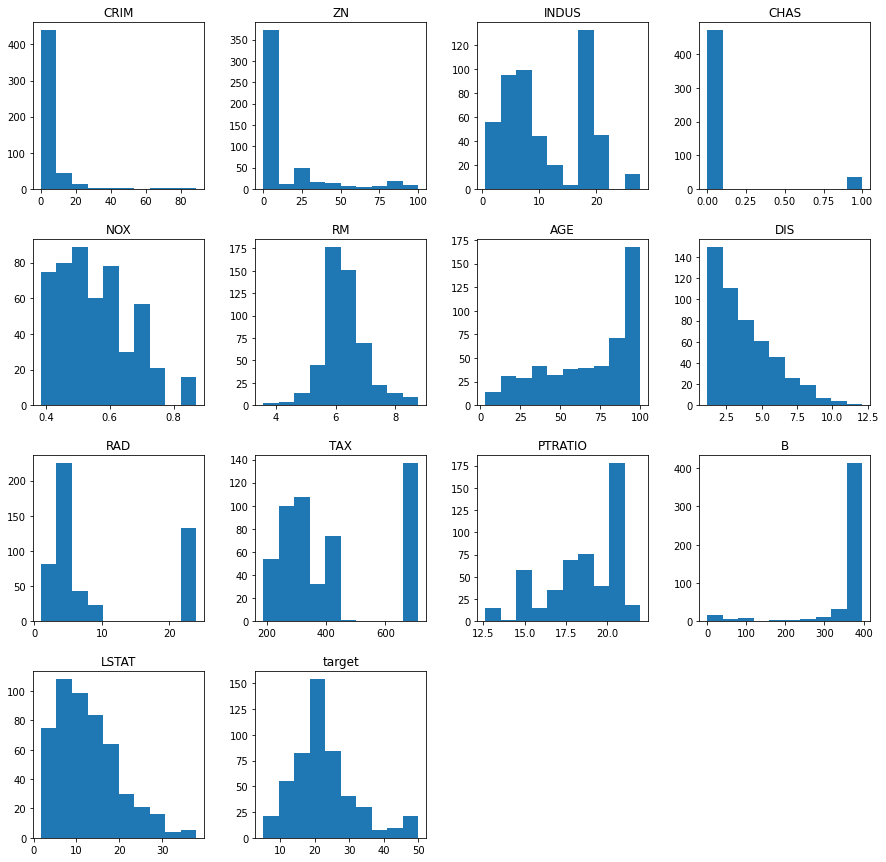

In [11]:
# Data visualizations

# histograms
df.hist(bins=10,figsize=(15, 15), grid=False)

# save the plot 
#plt.savefig('INSERT PATH')
plt.show()

## 5. Multivariate exploration

In [12]:
# correlation analysis
pd.set_option('precision', 2)
df.drop(['CHAS'], axis=1).corr(method='pearson')

,CRIM,ZN,INDUS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
CRIM,1.00,-0.20,0.41,0.42,-0.22,0.35,-0.38,0.63,0.58,0.29,-0.39,0.46,-0.39
ZN,-0.20,1.00,-0.53,-0.52,0.31,-0.57,0.66,-0.31,-0.31,-0.39,0.18,-0.41,0.36
INDUS,0.41,-0.53,1.00,0.76,-0.39,0.64,-0.71,0.60,0.72,0.38,-0.36,0.60,-0.48
NOX,0.42,-0.52,0.76,1.00,-0.30,0.73,-0.77,0.61,0.67,0.19,-0.38,0.59,-0.43
RM,-0.22,0.31,-0.39,-0.30,1.00,-0.24,0.21,-0.21,-0.29,-0.36,0.13,-0.61,0.70
AGE,0.35,-0.57,0.64,0.73,-0.24,1.00,-0.75,0.46,0.51,0.26,-0.27,0.60,-0.38
DIS,-0.38,0.66,-0.71,-0.77,0.21,-0.75,1.00,-0.49,-0.53,-0.23,0.29,-0.50,0.25
RAD,0.63,-0.31,0.60,0.61,-0.21,0.46,-0.49,1.00,0.91,0.46,-0.44,0.49,-0.38
TAX,0.58,-0.31,0.72,0.67,-0.29,0.51,-0.53,0.91,1.00,0.46,-0.44,0.54,-0.47
PTRATIO,0.29,-0.39,0.38,0.19,-0.36,0.26,-0.23,0.46,0.46,1.00,-0.18,0.37,-0.51


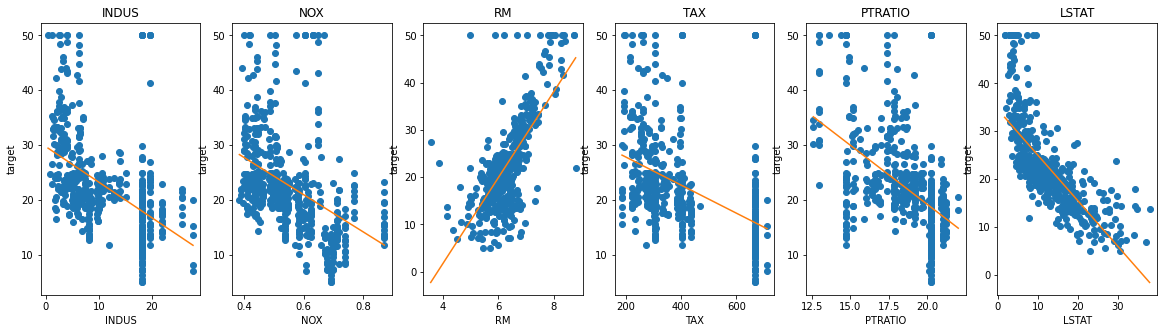

In [13]:
# bivariate plots with high correlation features (>0.4)
features = df.drop(['CRIM', 'ZN', 'CHAS',  'AGE', 'DIS', 'RAD', 'B', 'target'], axis = 1)
plt.figure(figsize=(20, 5))

# i: index
for i, col in enumerate(features.columns):
    # 3 plots here hence 1, 3
    plt.subplot(1, 6, i+1)
    x = df[col]
    y = df.target
    plt.plot(x, y, 'o')
    
    # Create regression line
    plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('target')

#plt.savefig('INSERT PATH')
plt.show()

## 6. Data Preprocessing 

In [14]:
# Delecte categorical variable CHAS 
# CHAS = Charles River dummy variable (= 1 if tract bounds river; 0 otherwise).
data = np.delete(data, 3, 1)
feature_names = np.delete(feature_names, 3)
feature_names

array(['CRIM', 'ZN', 'INDUS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT'], dtype='<U7')

In [15]:
# Standardize data 
mu = data.mean(axis=0)
sigma = data.std(axis=0)
data = (data - mu) / sigma

## 7. Machine learning Modeling with Tensorflow

In [16]:
# we split data into train and test, before categorizing y_train and y_test
idx = 475
x_train, y_train = data[:idx,:], y_cat[:idx]
x_test, y_test = data[idx:,:], y_cat[idx:]

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [17]:
# quick check on shapes
print(y_train.shape)
print(y_test.shape)

(475, 2)
(31, 2)


## 8. The Tensorflow Model

In [18]:
# we compute two distinct metrics
from tensorflow import keras
METRICS = [ 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.AUC(name='auc')
]

In [19]:
# neural network: model definition
def nn_model():
    x_in = Input(shape=(12,))
    x = Dense(40, activation='relu')(x_in)
    x = Dense(40, activation='relu')(x)
    x_out = Dense(2, activation='softmax')(x)
    nn = Model(inputs=x_in, outputs=x_out)
    nn.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=METRICS)
    return nn

In [20]:
# fitting and saving the model
nn = nn_model()
nn.summary()
nn.fit(x_train, y_train, batch_size=64, epochs=500, verbose=0)
nn.save('INSERT MODEL NAME.h5', save_format='h5')

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 12)]              0         
_________________________________________________________________
dense (Dense)                (None, 40)                520       
_________________________________________________________________
dense_1 (Dense)              (None, 40)                1640      
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 82        
Total params: 2,242
Trainable params: 2,242
Non-trainable params: 0
_________________________________________________________________


In [21]:
# loading the model and computing test performance
nn = load_model('INSERT MODEL NAME.h5')  
score = nn.evaluate(x_test, y_test, verbose=0)
print(nn.metrics_names)
print('Test accuracy: ', score[1])
print('Test AUC: ', score[2])

['loss', 'accuracy', 'auc']
Test accuracy:  0.83870965
Test AUC:  0.9219563


In [22]:
# saving model weights
nn.save_weights('INSERT PATH')

## 9. Generation of Counterfactual Explanations

In [23]:
# we choose a data point (whose outcome) to be explained
# in the notes we used x_test[1] and x_test[2]
X = x_test[1].reshape((1,) + x_test[1].shape)
shape = X.shape
X

array([[ 0.14638431, -0.48772236,  1.01599907,  0.51229565,  0.28402795,
         0.88990683, -0.7081777 ,  1.66124525,  1.53092646,  0.80657583,
         0.43348653,  0.84481853]])

In [24]:
# unnormalizing X - original values
orig = X * sigma + mu
orig

array([[4.87141e+00, 0.00000e+00, 1.81000e+01, 6.14000e-01, 6.48400e+00,
        9.36000e+01, 2.30530e+00, 2.40000e+01, 6.66000e+02, 2.02000e+01,
        3.96210e+02, 1.86800e+01]])

In [25]:
# checkpoint: use the fitted model or load another one
nn = load_model('INSERT MODEL NAME.h5')  

In [26]:
# alibi imports
import alibi
from alibi.explainers import CounterFactual

In [27]:
# setting the parameters for configurations 1,2
target_proba = 1.0
tol = 0.1
target_class = 'other'
max_iter = 1000
lam_init = 1
max_lam_steps = 100
learning_rate_init = 0.1 

In [28]:
# preparation to compute counterfactuals
cf = CounterFactual(nn, 
                    target_proba=target_proba, 
                    target_class='other',
                    tol=tol, 
                    shape=shape,
                    #early_stop=50,
                    feature_range= (x_train.min(axis=0), x_train.max(axis=0)), 
                    max_iter=max_iter, 
                    lam_init=lam_init, 
                    max_lam_steps=max_lam_steps,
                    learning_rate_init=learning_rate_init)

In [29]:
# computing counterfactuals
%%time
explanation = cf.explain(X)
counterfactual = explanation.cf['X'][0]
counterfactual

CPU times: user 31.5 s, sys: 1.65 s, total: 33.2 s
Wall time: 30.1 s


In [30]:
# probability of X
explanation.orig_proba

0.9358271956443787

In [31]:
# probabilities of the counterfactual
explanation.cf['proba']

array([[0.09846023, 0.90153974]], dtype=float32)

In [32]:
# counterfactual data point
counterfactual

array([ 0.14711657, -0.48772237,  1.0122546 ,  0.51205105,  0.28467363,
        0.8893798 , -0.70776516,  1.6612452 ,  1.5309265 ,  0.8068432 ,
        0.4333098 , -0.4740874 ], dtype=float32)

In [33]:
# checking classes
print('Original prediction: {}'.format(explanation.orig_class))
print('Counterfactual prediction: {}'.format(explanation.cf['class']))

Original prediction: 0
Counterfactual prediction: 1


In [34]:
# list of deltas with tolerance 1e-4 (see notes)
orig = X * sigma + mu
counterfactual = explanation.cf['X'] * sigma + mu
delta = counterfactual - orig
for i, f in enumerate(feature_names):
    if np.abs(delta[0][i]) > 1e-4:
        print('{}: {}'.format(f, delta[0][i]))

CRIM: 0.0062923410888346964
INDUS: -0.025663023494317372
RM: 0.0004532183223036057
AGE: -0.01482050894725262
DIS: 0.0008678233497860788
PTRATIO: 0.0005783043346632155
B: -0.016118760625147388
LSTAT: -9.409076955973617


In [35]:
# End of notebook